# Fine-Tuning

## Escolha do Dataset

O Dataset proposto para ser utilizado no tech challange é o **The AmazonTitles-1.3MM**. Este consiste em consultas textuais reais de usuários e títulos associados de produtos relevantes encontrados na Amazon e suas descrições, medidos por ações implícitas ou explícitas dos 
usuários.

Pelo tamanho do dataset, não sera possível disponibiliza-lo de forma direta aqui. Para executar esse processo, deve-se baixar o arquivo no [link](https://drive.google.com/file/d/12zH4mL2RX8iSvH0VCNnd3QxO4DzuHWnK/view) que foi fornecido pelo Tech Challange, extrair e inserir o "trn.json" na raiz do projeto.

## Preparação do Dataset

### Carregamento

Utilização do arquivo "trn.json" do Dataset proposto, apenas com as colunas "title" e "content" as quais serão utilizadas posteriormente no fine tuning do modelo de LLM, de forma que responda as informações da descrição do produto com base em pergunta sobre o título.

In [ ]:
! pip install pandas

In [1]:
import pandas as pd

# Carregando o arquivo JSONL inteiro
file_path = './trn.json'
df = pd.read_json(file_path, lines=True)

# Selecionando apenas as colunas desejadas
colunas_desejadas = ['title', 'content']
df_selecionado = df[colunas_desejadas]

# Exibindo as primeiras linhas para verificar o resultado
print(df_selecionado.head())


                                               title  \
0                        Girls Ballet Tutu Neon Pink   
1                           Adult Ballet Tutu Yellow   
2  The Way Things Work: An Illustrated Encycloped...   
3                                      Mog's Kittens   
4                              Misty of Chincoteague   

                                             content  
0  High quality 3 layer ballet tutu. 12 inches in...  
1                                                     
2                                                     
3  Judith Kerr&#8217;s best&#8211;selling adventu...  
4                                                     


In [2]:
# Verificando o número de linhas
df_selecionado.shape[0]

2248619

### Limpeza e pré-processamento

In [3]:
import numpy as np

# Substituindo valores vazios ("") por NaN
df_selecionado.replace("", np.nan, inplace=True)

# Removendo linhas com valores nulos
df_selecionado.dropna(inplace=True)

# Removendo linhas duplicadas
df_selecionado.drop_duplicates(inplace=True)

df_selecionado.shape[0]


C:\Users\leona\AppData\Local\Temp\ipykernel_19252\2741903638.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado.replace("", np.nan, inplace=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_19252\2741903638.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado.dropna(inplace=True)
C:\Users\leona\AppData\Local\Temp\ipykernel_19252\2741903638.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selecionado

1367131

Para utilizar o fine tunning do Gemini, há algumas limitações como por exemplo:
- The maximum input size per example is 40,000 characters.
- The maximum output size per example is 5,000 characters.

Nesse sentido, é necessário tratar para que não receba exemplos que ultrapasse esses valores.

In [4]:
# Filtrando linhas com menos de 40.000 caracteres na coluna "title"
df_selecionado = df_selecionado[df_selecionado['title'].apply(lambda x: len(x) <= 40000)]

# Filtrando linhas com menos de 5.000 caracteres na coluna "content"
df_selecionado = df_selecionado[df_selecionado['content'].apply(lambda x: len(x) <= 5000)]

In [5]:
df_selecionado.shape[0]

1361593

A uma limitação do tamanho de dados de treinamento que pode ser passado para o fine tuning com a lib (max 400 MB) e também limitação referente ao numero de exemplos que podemos utilizar multiplicado pleo número de épocas (len(examples) * epoch_count < 250.000). 

Nesse sentido, vamos precisar reduzir o dataset.

Primeiro vamos verificar o tamanho do "arquivo" do dataset selecionado.

In [6]:
import sys

dataset_size = sys.getsizeof(df_selecionado)
print(f"Tamanho atual do dataset: {dataset_size / (1024 * 1024)} MB")

Tamanho atual do dataset: 976.437991142273 MB


Remover primeiramente as linhas com base na quantidade de épocas exploradas, que consequentemente deve reduzir o tamanho em MB.

In [7]:
# Embaralhando o DataFrame
df_shuffled = df_selecionado.sample(frac=1, random_state=42).reset_index(drop=True)

**Calculando o limite permitido:**

In [8]:
epoch_count = 2

max_examples = 250000 // epoch_count
print(f"Pode-se usar até {max_examples} exemplos no dataset com {epoch_count} épocas.")

Pode-se usar até 125000 exemplos no dataset com 2 épocas.


**Reduzindo o Dataset:**

In [9]:
# Removendo as linhas excedentes
df_reduced = df_shuffled.iloc[:max_examples]

In [10]:
df_reduced.shape[0]

125000

In [11]:
new_size = sys.getsizeof(df_reduced)
print(f"Tamanho reduzido do dataset: {new_size / (1024 * 1024)} MB")

Tamanho reduzido do dataset: 88.50557327270508 MB


**Caso fosse necessário diminuir o tamanho ainda mais:**

In [ ]:
# # Quantidade de linhas totais no dataset
# total_rows = len(df_reduced)

# # Tamanho médio por linha
# average_row_size = dataset_size / total_rows

# # Limite de tamanho em bytes (400 MB)
# max_size = 400 * 1024 * 1024  # 400 MB em bytes

# # Calculando quantas linhas precisamos para ficar abaixo de 400 MB
# target_rows = int(max_size / average_row_size)

# # Removendo as linhas excedentes
# df_reduced = df_reduced.iloc[:target_rows]

# # Verificando o novo tamanho
# new_size = sys.getsizeof(df_reduced)
# print(f"Tamanho reduzido do dataset: {new_size / (1024 * 1024)} MB")

In [12]:
# Salvando o DataFrame reduzido em formato JSONL para melhor visualização dos dados finais
df_reduced.to_json('dataset_reduzido.jsonl', orient='records', lines=True)

vamos deixar o texto preparado para que esteja em um formato de pergunta, de forma que esteja simulando a pergunta do usuário para exemplificar no treinamento.

In [13]:
df_reduced['formatted_title'] = df_reduced['title'].apply(lambda x: f"What is the {x} product?")
df_reduced

C:\Users\leona\AppData\Local\Temp\ipykernel_19252\1906977488.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reduced['formatted_title'] = df_reduced['title'].apply(lambda x: f"What is the {x} product?")


,title,content,formatted_title
0,Freshwater Fishing: 1000 Tips From The Pros,The two have done their homework...a wonderful...,What is the Freshwater Fishing: 1000 Tips From...
1,Fisher-Price Growing Baby Pull Along Froggie,Where should we go? A fun pull-along friend pr...,What is the Fisher-Price Growing Baby Pull Alo...
2,More from Macrina: New Favorites from Seattle'...,&ldquo;Leslie Mackie is the goddess of bakers ...,What is the More from Macrina: New Favorites f...
3,Gridlock,Former U.S. senator Dorgan (D-North Dakota) an...,What is the Gridlock product?
4,Quiet Time Fashion Bed - Pink - 17&quot; x 12&...,Same Quiet Time quality in new fashion colors....,What is the Quiet Time Fashion Bed - Pink - 17...
...,...,...,...
124995,EApLANET&reg; Brother Compatible ink for LC-71...,Exclusively designed for EApLANET. High qualit...,What is the EApLANET&reg; Brother Compatible i...
124996,"T. H. Marine LCH-1W Cup Holder, Color White",LARGE CUP HOLDER WHITE,"What is the T. H. Marine LCH-1W Cup Holder, Co..."
124997,Ultimate Kids Toy Army Combat Set with Ak47 Gu...,Note: Small Parts. Choking hazard. Not for chi...,What is the Ultimate Kids Toy Army Combat Set ...
124998,Persil Universal-Gel Waschmittel 16 Waschladun...,Persil Universal Gel laundry detergent is suit...,What is the Persil Universal-Gel Waschmittel 1...


## Google AI Studio

In [ ]:
! pip install google-generativeai

### Chamada do Base (Foundation) Model

Antes de realizarmos o processo de execução do fine-tuning, testaremos com uma chamada no modelo base antes do treinamento, para que se obtenha uma base de análise após o fine-tuning.

#### Autenticação - OAuth

##### Pré requisitos

- Um Google Cloud Project
- Instalar o gcloud CLI localmente

Para realizar o fine tuning de um modelo base Gemini pelo Google AI Studio, é necessário fazer uma autenticação do tipo OAuth. 

Documentação de referência para OAuth: https://ai.google.dev/gemini-api/docs/oauth
 
_OAuth é apenas necessário para o fine tuning. Para a utilização do modelo fine tuned, pode utilizar API Key._

In [14]:
!gcloud auth application-default login \
    --client-id-file=client_secret.json \
    --scopes="https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.retriever,https://www.googleapis.com/auth/generative-language.tuning"

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=610173493762-cbik4ek8b40oo3hq52bk1hbam4egjr0r.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.retriever+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fgenerative-language.tuning&state=gkkfLVdL1909ADsMI898X5CYRoHKP5&access_type=offline&code_challenge=oX1OmClRC-97tJ-atgI-v-9IJw8EVDoXGT5NbissprU&code_challenge_method=S256


Credentials saved to file: [C:\Users\leona\AppData\Roaming\gcloud\application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).


In [15]:
! gcloud auth application-default print-access-token

ya29.a0AcM612wggyCAiHfulN1wyRZdthZniWb5ulKcvwh2OpolGMC7RKD-jYif3YCyiZNtKsEXcLVN3_SmLjdvP_q31szqCt5LwHEYbQFqLgyqCasHahLrne6wTkl4HTLCHxJJxkvyHuT1dFCbtJtfqzF5hjtc2SLqjgxSfVVfjLLEaCgYKAfsSARASFQHGX2MimLO1vK-OueCL9rZtbLYUEA0175


In [ ]:
# ! pip install python-dotenv

In [16]:
# import os
import google.generativeai as genai
# from dotenv import load_dotenv

# load_dotenv()

# genai.configure(api_key=os.getenv("GEMINI_API_KEY"))

base_model = "models/gemini-1.5-flash-001-tuning"
model_before = genai.GenerativeModel(
  model_name=base_model,
)

result_before = model_before.generate_content("What is the Memorex Sport CD Boombox product?")
result_before.text

c:\Projects\ia-para-devs-tech-challenge-fase3\tech_challenge_fase3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Unfortunately, I cannot find any information about a product called "Memorex Sport CD Boombox". It\'s possible that:\n\n* **The product name is incorrect:**  There might be a slight variation in the name, or it might be a different model altogether.\n* **The product is discontinued:**  Memorex, like many companies, discontinues older models, and information about them might be scarce online.\n* **The product was region-specific:** It\'s possible the product was only sold in a certain region and isn\'t widely known.\n\n**To find more information, I recommend:**\n\n1. **Double-checking the product name:**  Ensure you have the correct name and try searching again.\n2. **Searching for similar Memorex products:** Look for other Memorex boomboxes or CD players and see if any resemble the one you are looking for.\n3. **Checking online marketplaces:** Sites like eBay or Amazon might have old product listings that can provide more details.\n4. **Contacting Memorex directly:** You can try reach

### Execução do Fine-Tuning

#### Autenticação - OAuth

##### Pré requisitos

- Um Google Cloud Project
- Instalar o gcloud CLI localmente

Para realizar o fine tuning de um modelo base Gemini pelo Google AI Studio, é necessário fazer uma autenticação do tipo OAuth. 

Documentação de referência para OAuth: https://ai.google.dev/gemini-api/docs/oauth
 
_OAuth é apenas necessário para o fine tuning. Para a utilização do modelo fine tuned, pode utilizar API Key._

In [ ]:
!gcloud auth application-default login \
    --client-id-file=client_secret.json \
    --scopes="https://www.googleapis.com/auth/cloud-platform,https://www.googleapis.com/auth/generative-language.retriever,https://www.googleapis.com/auth/generative-language.tuning"

In [ ]:
! gcloud auth application-default print-access-token

#### Criação do tuned model

##### Preparando dados de treinamento

O dataset foi limpado e pré processado acima. Porém para utilizar no trainamento é necessário passar as informações no formato de lista com "text_input" e "output", passando como exemplos de entrada e saída esperada.

In [17]:
training_data = df_reduced.apply(lambda row: {"text_input": row['formatted_title'], "output": row['content']}, axis=1).tolist()

##### Execução

In [18]:
operation = genai.create_tuned_model(
    display_name="tech-challenge-fase3",
    source_model=base_model,
    epoch_count=epoch_count,
    batch_size=4,
    learning_rate=0.001,
    training_data=training_data,
)

##### Checando progresso do tuning

In [19]:
import time

for status in operation.wait_bar():
  time.sleep(10)

 93%|█████████▎| 58382/62500 [41:32:08<3:18:49,  2.90s/it]  

##### Resultados tuning

Uma vez que o tuning esteja completo, podemos visualizar a curva de perda dos resultados do ajuste. A curva de perda mostra o quanto as previsões do modelo desviam das saídas ideais.

In [1]:
! pip install seaborn


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [13]:
# model = operation.result()
# model

## Carregando informações do modelo finalizado (nome obtido pelo interface web)
name = 'tunedModels/techchallengefase3-m3khfk21t2bh'
model = genai.get_tuned_model(name)

In [11]:
model.state

<State.ACTIVE: 2>

<Axes: xlabel='epoch', ylabel='mean_loss'>

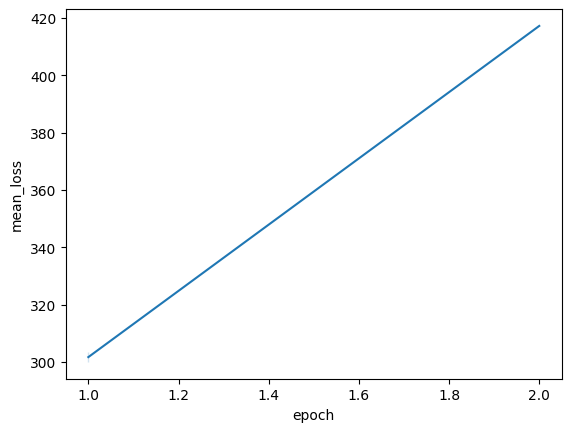

In [10]:
import pandas as pd
import seaborn as sns

snapshots = pd.DataFrame(model.tuning_task.snapshots)

sns.lineplot(data=snapshots, x = 'epoch', y='mean_loss')

### Geração de respostas

In [14]:
model = genai.GenerativeModel(model_name=name)

In [15]:
result = model.generate_content('What is the Memorex Sport CD Boombox product?')
result.text

'The Memorex Sport boombox brings a sleek styling look with quality stereo sound. Featuring a double cassette tape deck, radio and CD player with CDMP3 compatibility, the Memorex Sport offers many entertainment options in one unit. The Sport features a high-power output speaker that provides a powerful sound experience for up to 100 hours of play time. It also features an adjustable bass and treble control and an LCD display for radio stations and clock. The Sport has a 3.5mm audio input that lets you connect your favorite MP3 players and digital audio players to the Sport via the auxiliary line at the back. In addition, the Sport can be set to play radio, CD and tape at random or play CD/tape repeat. It also has an alarm function that includes a sleep timer and a timer for CD, tape and radio. You can also utilize its 5-band equalizers for a clear and powerful sound. The Sport is easy to use with its front panel controls and display. Other features include a headphone jack and a detach

Agora, após o tuning no modelo, ele conseguiu responder a pergunta com informações do produto de fato!

No entanto ele foi "criativo" e colocou com dizeres diferente indo até além que o content original.

Comparando respostas antes, depois e conteúdo original:

Antes: 'Unfortunately, I cannot find any information about a product called "Memorex Sport CD Boombox". It\'s possible that:\n\n* **The product name is incorrect:**  There might be a slight variation in the name, or it might be a different model altogether.\n* **The product is discontinued:**  Memorex, like many companies, discontinues older models, and information about them might be scarce online.\n* **The product was region-specific:** It\'s possible the product was only sold in a certain region and isn\'t widely known.\n\n**To find more information, I recommend:**\n\n1. **Double-checking the product name:**  Ensure you have the correct name and try searching again.\n2. **Searching for similar Memorex products:** Look for other Memorex boomboxes or CD players and see if any resemble the one you are looking for.\n3. **Checking online marketplaces:** Sites like eBay or Amazon might have old product listings that can provide more details.\n4. **Contacting Memorex directly:** You can try reaching out to Memorex customer service for assistance in finding information about the product.\n\nHopefully, with a bit more investigation, you\'ll be able to find what you are looking for. \n'

Depois: 'The Memorex Sport boombox brings a sleek styling look with quality stereo sound. Featuring a double cassette tape deck, radio and CD player with CDMP3 compatibility, the Memorex Sport offers many entertainment options in one unit. The Sport features a high-power output speaker that provides a powerful sound experience for up to 100 hours of play time. It also features an adjustable bass and treble control and an LCD display for radio stations and clock. The Sport has a 3.5mm audio input that lets you connect your favorite MP3 players and digital audio players to the Sport via the auxiliary line at the back. In addition, the Sport can be set to play radio, CD and tape at random or play CD/tape repeat. It also has an alarm function that includes a sleep timer and a timer for CD, tape and radio. You can also utilize its 5-band equalizers for a clear and powerful sound. The Sport is easy to use with its front panel controls and display. Other features include a headphone jack and a detachable AC/DC power cord.'

Content Original: 'This uniquely designed, sporty boombox features a rugged outer shell, perfect for toting to outside sporting events, the beach, or your yard. Memorex Portable Sport CD Boombox features an AM\/FM radio with digital readout, a programmable CD player, and an audio input for connecting your MP3 player or other digital audio device. MP3851BLK includes a bass boost system, AC\/DC operation, and has CD, CD-R\/-RW playback.'

Caso queiramos que a resposta esteja mais próxima da original, podemos experimentar diminuindo a temperatura do modelo ao gerar conteúdo, de forma que ele fique menos "criativo".

In [17]:
result = model.generate_content('What is the Memorex Sport CD Boombox product?',generation_config={'temperature': 0})
result.text

'The Memorex Sport CD Boombox is a portable boombox that is perfect for the active lifestyle. It features a built-in AM/FM radio, CD player, and auxiliary input for MP3 players. The boombox also has a built-in clock and alarm, and a 3.5mm headphone jack. The Memorex Sport CD Boombox is a great way to enjoy your favorite music while on the go.'

**Depois com temperature 0:** 'The Memorex Sport CD Boombox is a portable boombox that is perfect for the active lifestyle. It features a built-in AM/FM radio, CD player, and auxiliary input for MP3 players. The boombox also has a built-in clock and alarm, and a 3.5mm headphone jack. The Memorex Sport CD Boombox is a great way to enjoy your favorite music while on the go.'

**Content Original:** 'This uniquely designed, sporty boombox features a rugged outer shell, perfect for toting to outside sporting events, the beach, or your yard. Memorex Portable Sport CD Boombox features an AM\/FM radio with digital readout, a programmable CD player, and an audio input for connecting your MP3 player or other digital audio device. MP3851BLK includes a bass boost system, AC\/DC operation, and has CD, CD-R\/-RW playback.'

Explorarmos mais alguns outros produtos.

In [33]:
#Modelo base
result = model_before.generate_content('What is the Jerry Rocks product?')
print(f'Antes do tuning: {result.text}')

print('----------')

# Modelo tuned
result = model.generate_content('What is the Jerry Rocks product?')
print(f'Depois do tuning: {result.text}')

print('----------')

# Modelo tuned com temperature 0
result = model.generate_content('What is the Jerry Rocks product?',generation_config={'temperature': 0})
print(f'Depois do tuning com temperature 0: {result.text}')

print('----------')

# Content Original do dataset reduzido
print("Content Original: The top-sellingRocks!series turns to the man who literally epitomizes rock: Jerry Lee Lewis! There have been plenty of Jerry Lee compilations through the years, but this is the first to feature an incredible 80 minutes (well, 79 minutes and 50 seconds) of wall-to-wall piano pounding Rock 'n' Roll. It's also the first to include songs from Jerry Lee's Sun and Mercury recordings in one set. Twenty-one years in the life of Jerry Lee Lewis...and all the big rock hits you'd expect, likeWhole Lotta Shakin',Great Balls Of Fire,High School Confidential,I'm On Fire,Chantilly Lace, andMe And Bobbie McGee, as well as rarities and obscurities likeReal Wild Child,House Of Blue Lights, andDon't Boogie Woogie When You Say Your Prayers Tonight\"\". 2006 marked the 50th anniversary of Jerry Lee's first record release and what better way to mark that anniversary than with 80 minutes of his best rockers. CD Digipac with 40-page booklet.")

Antes do tuning: There doesn't seem to be a product called "Jerry Rocks." It's possible that you're thinking of something else, or it could be a very niche product that I haven't encountered in my training data. 

To help me understand what you're looking for, could you provide more context? Perhaps:

* **A different spelling or variation of the name.**
* **A description of the product's purpose or category.**
* **Any brand or company associated with it.**

With more information, I might be able to assist you! 

----------
Depois do tuning: Jerry is the boy whose life changed forever.  The Jerry Rocks story follows Jerry's progress as he changes from a young boy who loves to swim to a young man studying to become an artist.  Jerry overcomes his fear of the water by learning to swim and goes on to learn to scuba dive.  Jerry finds a gift for art and studies to become an artist.  He is still afraid of the water and has problems overcoming his fear of the deep.  With his friends and famil

In [35]:
#Modelo base
result = model_before.generate_content('What is the SE - Storage Container Set - Aluminum, Glass Top Lid, Round, 12Pc - 87512DB-P product?')
print(f"Antes do tuning: {result.text}")

print('----------')

# Modelo tuned
result = model.generate_content('What is the SE - Storage Container Set - Aluminum, Glass Top Lid, Round, 12Pc - 87512DB-P product?')
print(f"Depois do tuning: {result.text}")

print('----------')

# Modelo tuned com temperature 0
result = model.generate_content('What is the SE - Storage Container Set - Aluminum, Glass Top Lid, Round, 12Pc - 87512DB-P product?',generation_config={'temperature': 0})
print(f"Depois do tuning com temperature 0: {result.text}")

print('----------')

# Content Original do dataset reduzido
print("Content Original: This 12 piece aluminum box set features aluminum bodies and clear glass top lids. They have dimensions of 2in. X 7\/8in. In diameter.")

<>:20: SyntaxWarning: invalid escape sequence '\/'
<>:20: SyntaxWarning: invalid escape sequence '\/'
C:\Users\leona\AppData\Local\Temp\ipykernel_5624\2896582953.py:20: SyntaxWarning: invalid escape sequence '\/'
  print("Content Original: This 12 piece aluminum box set features aluminum bodies and clear glass top lids. They have dimensions of 2in. X 7\/8in. In diameter.")


Antes do tuning: I do not have access to real-time information, including product details like the one you described. To get information about the "SE - Storage Container Set - Aluminum, Glass Top Lid, Round, 12Pc - 87512DB-P" product, I recommend you try the following:

* **Search online retailers:** Look for the product on websites like Amazon, Walmart, Target, etc.  
* **Check the manufacturer's website:** If you know the brand "SE," you can visit their website for details. 
* **Use a search engine:** Try searching for the product name and/or model number using Google or other search engines.

These methods should help you find information about the product, such as features, dimensions, price, and availability. 

----------
Depois do tuning: -Includes 2 each of 3 different sizes in aluminum containers with glass lids
-Ideal for storing spices, oils and other pantry items in the kitchen.
-The containers are airtight, so you can store delicate or perishable foods at room temperature.